<a href="https://colab.research.google.com/github/ZazzyDictionary/SPY-experiment/blob/main/SPY_PA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install yfinance
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

     |████████████████████████████████| 5.5MB 6.3MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=1e9e220f846aadd4753edce4ec6b90f0e398748517054870c19970f2fb50108a
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [16]:
stocks = ["SPY"]

In [17]:
data = yf.download(stocks, start="2000-01-01", end="2021-02-10")

[*********************100%***********************]  1 of 1 completed


In [18]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,148.25000,148.25000,143.875000,145.4375,98.146072,8164300
2000-01-04,143.53125,144.06250,139.640625,139.7500,94.307983,8089800
2000-01-05,139.93750,141.53125,137.250000,140.0000,94.476685,12177900
2000-01-06,139.62500,141.50000,137.750000,137.7500,92.958336,6227200
2000-01-07,140.31250,145.75000,140.062500,145.7500,98.356987,8066500


In [19]:
closedStocks = data.loc[:, "Close"].copy()

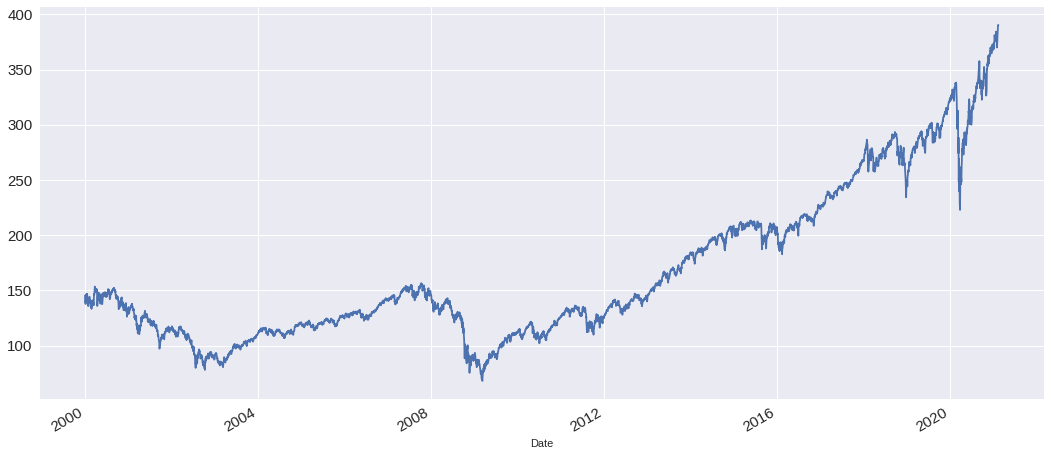

In [20]:
closedStocks.plot(figsize = (18, 8), fontsize = 15)
plt.style.use("seaborn")
plt.show()